---

<center>
<h1>Pronóstico de la productividad forrajera y balance</h1>
<h1>hídrico en la región de los pastizales del Río de la Plata</h1>
</center>

---


<br>
<br>
<ul>
    <li>Bartol, Tomás Augusto</li>
    <li>Peiretti, Pablo </li>
    <li>Sánchez, Milagros Verónica </li>
</li>
</ul>


<br>
<h2>Abstract</h2>

This notebook was created with the purpose of introducing the use of multispectral satellite images as a tool for predicting forage production and water balance in the grasslands of the Río de la Plata. Based on this, the aim is to achieve a more efficient and precise management of resources. Additionally, there will be an attempt to increase livestock productivity by reducing variability in forage production. 

---

# Modules 

This section contains the import statements for external Python modules that are used throughout the notebook. This section is where external libraries or packages are loaded in order to provide additional functionality beyond the basic Python capabilities


In [522]:
### Load the imports ### 
import numpy as np
import pandas as pd
import geopandas as gpd
import tensorflow as tf
from tensorflow.keras import layers, models
from keras.layers import Input, Dense, LSTM
from matplotlib import pyplot as plt
from datetime import datetime
from sklearn.model_selection import train_test_split
import matplotlib.dates as mdates
import folium
from branca.colormap import linear
from IPython.display import display
from folium import plugins

--- 

# Utilities

The Utilities Section in this Jupyter Notebook serves as a collection of tools and auxiliary functions designed to streamline common tasks, enhance code efficiency, and provide reusable functionalities.

In [695]:
""" 
We need a few utilities to simplify object-oriented programming in Jupyter notebooks. One
of the challenges is that class definitions tend to be fairly long blocks of code. Notebook
readability demands short code fragments, interspersed with explanations, a requirement
incompatible with the style of programming common for Python libraries. The first utility
function allows us to register functions as methods in a class after the class has been created.
""" 

class Utils:
    
    
    #Register functions as methods in created class.
    @staticmethod
    def plot_hisass(Class): #@save

        def wrapper(obj):
            setattr(Class, obj.__name__, obj)
        
        return wrapper
    
    @staticmethod    
    def plot_training_history(fig, history, metric):

        validation_metric = f"val_{metric}"

        fig.plot(history.history[metric], label=f"Training {metric}")
        fig.plot(history.history[validation_metric], label=f"Validation {metric}")
        fig.set_xlabel("Epoch")
        fig.set_ylabel(f"{metric}")
        fig.legend()

        merged_mae_lists = history.history[f"{metric}"][0:] + history.history[f"val_{metric}"][0:]
        highest_loss = max(merged_mae_lists)
        lowest_loss = min(merged_mae_lists)
        delta = highest_loss - lowest_loss
        top_of_y_axis = highest_loss + (delta * 0.05)
        bottom_of_y_axis = lowest_loss - (delta * 0.05)

        fig.set_ylim([bottom_of_y_axis, top_of_y_axis])



--- 

# Macros 

The Globals and Macros section in this codebase serves as a centralized hub for managing global variables and macros that impact the entire project. This section is dedicated to storing constants, configuration parameters, and reusable macros that streamline the development process and ensure consistency across various components.

In [524]:
DATABASE_PATH = "Database\database.csv"

---

# Data

In this dedicated segment, our primary emphasis will be on the comprehensive visualization and skillful manipulation of the data provided by the MODIS remote sensor. We will delve into the intricacies of presenting the information in a visually impactful manner, ensuring that we not only harness the power of visualization techniques but also adeptly navigate the nuances of manipulating the MODIS dataset for meaningful insights.

In [525]:
"""
Class that manage data and provides methods to visualize it. 
"""

class DataManager(pd.DataFrame):
    
    def load_data(self, filepath):
        try:
            # Load data into the DataFrame itself
            self.__init__(pd.read_csv(filepath))
            self['date'] = pd.to_datetime(self['date'])
            print(f"Data loaded successfully from {filepath}")
        except Exception as e:
            print(f"Error loading data: {e}")

    def date_to_timestamp(self): 
        
        self['timestamp_date'] = pd.to_datetime(self['date'], format='%m/%d/%Y').map(pd.Timestamp.timestamp)

        #convert_to_timestamp = lambda date_str: (
        #    int(datetime.strptime(date_str, "%m/%d/%Y").timestamp()) 
        #    ) if not np.issubdtype(np.array([date_str]).dtype, np.integer) else date_str
        #self['date'] = self['date'].apply(convert_to_timestamp)


    def show_correlation(self,fig, var1, var2): 

        fig.scatter(self[f"{var1}"], self[f"{var2}"], c='blue', alpha=0.7, s=5)
        r=correlation = self[f"{var1}"].corr(self[f"{var2}"])
        r=round(r,3)
        fig.set_title(f"Correlation between {var1} and {var2} (R = {r})")
        fig.set_xlabel(f'{var1}'.upper())
        fig.set_ylabel(f'{var2}'.upper())
        fig.grid(True)

    def show_ppna_fixed_position (self, fig, latitude, longitude):

        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])
        fig.plot(fix_position_df['date'], fix_position_df['ppna'], c='blue')
        fig.set_title("PPNA over time in fixed location")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.grid(True)

    def show_ppna_year_comparision_fixed_position(self, fig, year1, year2, latitude, longitude): 
        
        fix_position_df = self[(self['longitude'] == longitude) & (self['latitude'] == latitude)].copy()
        fix_position_df['date'] = pd.to_datetime(fix_position_df['date'])

        for year in fix_position_df['date'].dt.year.unique():
            if year == year1 or year == year2:
                year_data = fix_position_df[fix_position_df['date'].dt.year == year]
                dias_meses = [fecha.strftime('%d-%m') for fecha in year_data['date']]
                fig.plot(dias_meses, year_data['ppna'], label=f'Year {year}')

        # Adjusting the x-axis labels for better readability
        fig.tick_params(axis='x', rotation=45)
        fig.set_title("PPNA Comparison over the years")
        fig.set_xlabel('Date')
        fig.set_ylabel('PPNA')
        fig.legend()
        fig.grid(True)

    def show_heat_map(self):

        # Crear un mapa centrado en la ubicación media de tus datos
        mapa = folium.Map(location=[self['latitude'].mean(), self['longitude'].mean()], zoom_start=6)

        # Creo un df con fecha, latitude, longitud y valor de la ppna 
        ppna_heatmaptime_df = self[['date','latitude','longitude','ppna']]
        ppna_heatmaptime_df['date'] = ppna_heatmaptime_df['date'].sort_values(ascending=True)
        data = []
        for _, d in ppna_heatmaptime_df.groupby('date'):
            data.append([[row['latitude'], row['longitude'], row['ppna']] for _, row in d.iterrows()])
        data

        #creo el indice de tiempo para graficar en el mapa 
        time_index = list(ppna_heatmaptime_df['date'].astype('str').unique())


        plugins.HeatMapWithTime(data,
                        index=time_index,
                        auto_play=True,
                        radius=10,
                        use_local_extrema=True
                    ).add_to(mapa)


        # Agrego labels
        """
        Lo dejo comentado por que por performance tarda mucho, despues vemos si lo necesitamos como solucionarlo 
        percentage_to_label = 5  # Porcentaje de puntos para los que se agregarán etiquetas
        total_points = sum(len(points) for points in data)
        points_to_label = [point for points in data for point in points if hash(tuple(point)) % 100 < percentage_to_label]

        for lat, lon, value in points_to_label:
            label = value
            folium.Marker(location=[lat, lon], popup=label).add_to(mapa)

        """

        display(mapa)

    def normalize_data(self):
        mean = self.mean()
        std = self.std()
        self[['ppna', 'ppt', 'temp']] = (self[['ppna', 'ppt', 'temp']] - mean[['ppna', 'ppt', 'temp']]) / std[['ppna', 'ppt', 'temp']]


In [556]:
ppna_df = DataManager()
ppna_df.load_data(DATABASE_PATH) 
ppna_df.info()

Data loaded successfully from Database\database.csv
<class '__main__.DataManager'>
RangeIndex: 690000 entries, 0 to 689999
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         690000 non-null  int64         
 1   date       690000 non-null  datetime64[ns]
 2   longitude  690000 non-null  float64       
 3   latitude   690000 non-null  float64       
 4   ppna       690000 non-null  float64       
 5   ppt        690000 non-null  float64       
 6   temp       690000 non-null  float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 36.9 MB



## Data Visualization 


In [527]:
ppna_df.head()

,id,date,longitude,latitude,ppna,ppt,temp
0,0,2001-01-01,-56.83242,-31.544792,405.340618,76.155505,24.333897
1,1,2001-01-17,-56.83242,-31.544792,362.433361,91.647396,23.921929
2,2,2001-02-02,-56.83242,-31.544792,420.441046,80.999538,24.132180
3,3,2001-02-18,-56.83242,-31.544792,335.261458,88.673292,26.170466
4,4,2001-03-06,-56.83242,-31.544792,301.399079,5.496469,24.043910


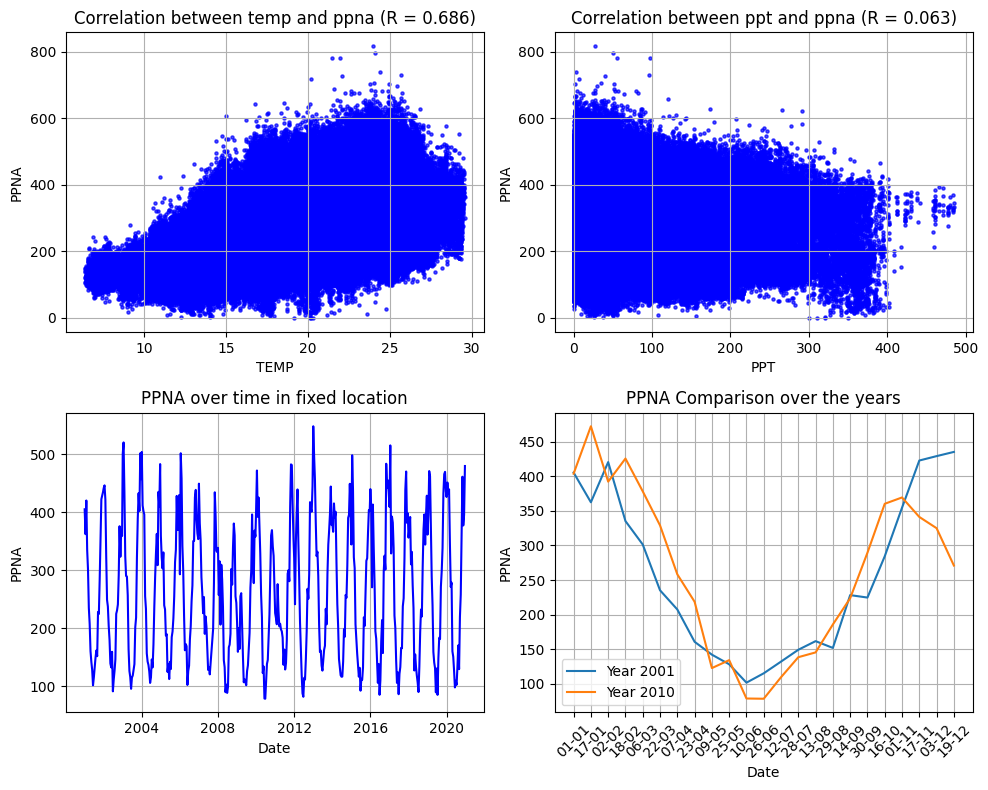

In [528]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
pd.options.mode.chained_assignment = None

ppna_df.show_correlation(axes[0,0], 'temp', 'ppna')
ppna_df.show_correlation(axes[0,1], 'ppt', 'ppna')
ppna_df.show_ppna_fixed_position(axes[1,0], ppna_df['latitude'][100], ppna_df['longitude'][100])
ppna_df.show_ppna_year_comparision_fixed_position(axes[1,1], 2001, 2010, ppna_df['latitude'][0], ppna_df['longitude'][0])

fig.tight_layout()
plt.show()

In [529]:
#ppna_df.show_heat_map()

## Data Managment

In [557]:
"""
Convert from date to timestamp format
""" 
ppna_df.date_to_timestamp()

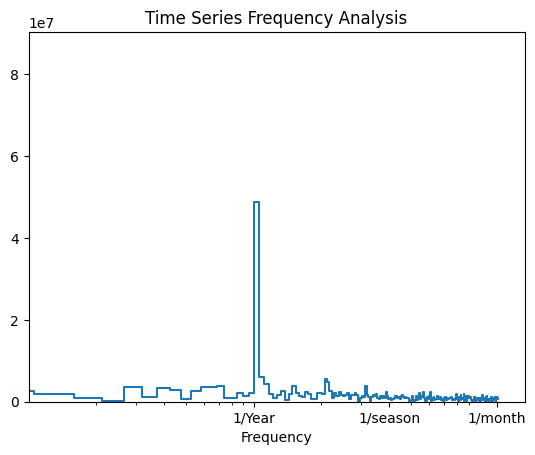

In [531]:
"""
Temporal periodicity analysis of our data set, where it can be seen that it has a very important annual periodicity.
"""

# group dataframe by date 
combined_series = ppna_df.groupby(['date'])['ppna'].sum().sort_index()


# Apply FFT
fft = tf.signal.rfft(combined_series)
f_per_dataset = np.arange(0, len(fft))


n_samples_h = len(combined_series)
f_sample = 15 #1 sample every 15 days 
years_per_dataset = n_samples_h * f_sample / 365  #number of samples * frecuency sample day * num of days in a year give me the number of years 
f_per_year = f_per_dataset / years_per_dataset

# Grafica la amplitud de las frecuencias en una escala de logaritmo.
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, max( np.abs(fft) /2))
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 4, 12], labels=['1/Year', '1/season', '1/month'])
plt.title('Time Series Frequency Analysis' )
plt.xlabel('Frequency')
plt.show()

Text(0.5, 1.0, 'Time signal')

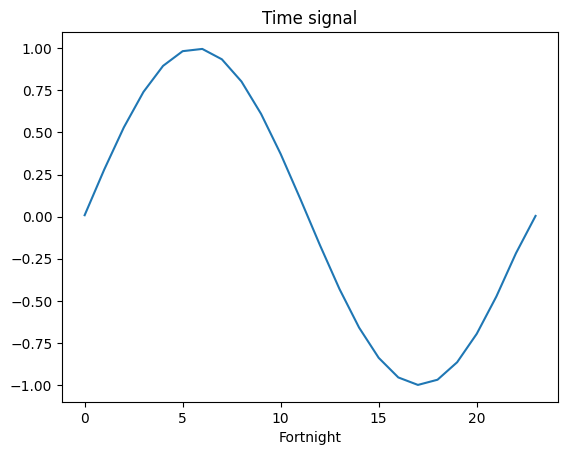

In [558]:
"""
Time in seconds is not a useful input for the model. Being meteorological data, it exhibits clear daily and annual periodicity. There are many ways to deal with this periodicity.
You can obtain usable signals by using sine and cosine transformations to remove the "Time of day" and "Time of year" signals.
As we previously analyzed, the most important time dependence is annual, therefore, we will use a time signal with an annual period.
"""
day = 24*60*60
year = (365.2425)*day


ppna_df['date_signal'] = np.sin(ppna_df['timestamp_date'] * (2 * np.pi / year))

plt.plot(np.array(ppna_df['date_signal'])[:24]) #veinticinco muestras son casi un año (15 * 24 = 360 dias) y vemos ue se cumple un periodo de la señal temporal
plt.xlabel('Fortnight')
plt.title('Time signal')



In [725]:
"""
Divide the dataframe into three sections (train, test, validation) with roughly a 70-20-10 distribution. 
As we have 20 years of data, it is going to be diveded into 14 years, 4 years and 2 years (70%,20% and 10%).
The samples are divided secuentially to improve the RNN performance.
"""

#ppna_df =  ppna_df[(ppna_df['longitude'] == ppna_df['longitude'][100]) & (ppna_df['latitude'] == ppna_df['latitude'][100])].copy() #-> lo hago para una sola ubicacion, despues hay que ver como cambiar esto 
train_df = DataManager(ppna_df[ppna_df['date'] < '2014-01-01'][[ 'date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])
val_df =  DataManager(ppna_df[(ppna_df['date'] >= '2014-01-01') & (ppna_df['date'] < '2019-01-01')][[ 'date_signal', 'latitude', 'longitude', 'ppt', 'temp', 'ppna']])
test_df = DataManager(ppna_df[ppna_df['date'] >= '2019-01-01'][['date_signal', 'latitude', 'longitude', 'ppt','temp', 'ppna']])

In [726]:
"""
Normalization of every dataframe. The chosen normalization uses mean and standard deviation
Every Dataframe must be normalized by the same values, hence the train df mean and deviation are saved

(También es discutible que el modelo no debería tener acceso a valores futuros en el conjunto de entrenamiento 
durante el entrenamiento, y que esta normalización debería hacerse usando promedios móviles. Ese no es el enfoque 
de este tutorial, y los conjuntos de validación y prueba aseguran que obtenga métricas (algo) honestas. 
Entonces, en aras de la simplicidad, este tutorial usa un promedio simple.) 

https://medium.com/@spinjosovsky/normalize-data-before-or-after-split-of-training-and-testing-data-7b8005f81e26
https://datascience.stackexchange.com/questions/27615/should-we-apply-normalization-to-test-data-as-well
"""
train_df.normalize_data()
val_df.normalize_data()
test_df.normalize_data()

### Data Window

We first need to prepare the data to be fed into an LSTM. The LSTM model learns a function that maps a sequence of past observations as input to an output observation. As such, the sequence of observations must be transformed into multiple examples from which the LSTM can learn.

To make it concrete in terms of the speed prediction problem, we choose to use 1 year of historical observations to predict the future, lets say, 15 days ahead. Hence, we would first reshape the timeseries data into windows of 24 historical observations for each segment as the input and the speed 15 days later is the label we are interested in predicting. We use the sliding window approach to prepare the data. This is how it works:

Starting from the beginning of the timeseries, we take the first 24 records as the 24 input features and the speed 1 timesteps head (15 days) as the ppna we want to predict.

Shift the timeseries by one timestep and take the 24 observations from the current point as the input features and the speed 15 days ahead as the output to predict.

Keep shifting by 1 timestep and picking the 24 timestep window from the current time as input feature and the speed one hour ahead of the 10th timestep as the output to predict, for the entire data.

The above steps are done for latitude and longitude. 

The function below returns the above transformed timeseries data for the model to train on. The parameter seq_len is the size of the past window of information. The pre_len is how far in the future does the model need to learn to predict.

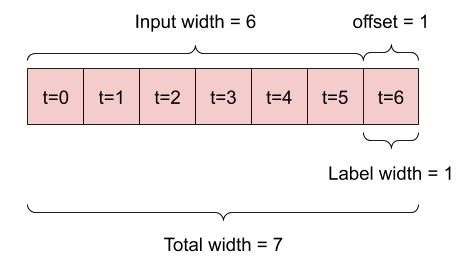

In [696]:
"""
This function is main in a LSTM model, prepare the data in form of past observations and future lable. For example, if the data is [1,2,3,4,5,6,7,8,9,10], the seq_len = 5 and the pre_len = 1: 
past_data = [[1],[2],[3],[4],[5]] , label data = [6]
past_data = [[2],[3],[4],[5],[6]] , label data = [7]
and so on...
"""

# Apply decorator to add the sequence data preparation to DataManager class 
@Utils.plot_hisass(DataManager)
def sequence_data_preparation(self, seq_len, pre_len):

    past_data = []  # Window for the past 
    label_data = []  # Predict next value 

    for i in range(self.shape[0] - int(seq_len + pre_len - 1)):
        a = self[i: i + seq_len + pre_len] 
        past_data.append(a[:seq_len])
        label_data.append(a[-1:]['ppna'])

    past_data = np.array(past_data)
    label_data = np.array(label_data)

    return past_data, label_data


--- 

# Recurrent Neuronal Network

In this section, we delve into the examination and analysis of various topologies within recurrent neural networks (RNNs) with the primary goal of estimating and predicting the productivity of forage production. Forage production, a critical aspect of agricultural ecosystems, can be influenced by a multitude of factors, and leveraging the capabilities of RNNs allows us to capture the temporal dependencies inherent in such dynamic systems.

## LSTM

We will embark on the construction of a Long Short-Term Memory (LSTM) neural network tailored for the PPNA. Leveraging the power of LSTM architecture, we aim to develop a robust model capable of capturing temporal dependencies within the data, ultimately enhancing our ability to forecast PPNA trends. Throughout this endeavor, we will explore the intricacies of LSTM networks, fine-tune model parameters, and implement effective training strategies to optimize predictive accuracy.

### LSTM - One Shot

A recurrent model can learn to use a long history of inputs if it is relevant for the predictions the model makes. 
Here, the model will accumulate internal state over a year (24 samples) before making a single prediction for the next 15 days (1 sample).

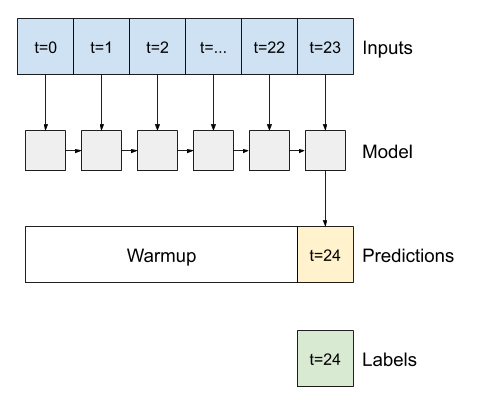

In [769]:
INPUT_STEPS = 24 #1 Year
OUTPUT_STEPS = 1 #15 DAYS
train_sequence, train_labels = train_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
val_sequence, val_labels = val_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
test_sequence, test_labels = test_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", train_sequence.shape)
print("label sequence: (num train data, label, 1) -> ", train_labels.shape)

train sequence: (num train data, past_data, features) -> (448476, 24, 6)
label sequence: (num train data, label, 1) ->  (448476, 1)


In [776]:
"""
Neuronal Network Model for LSTM one shot 
"""

LEARNING_RATE = 0.000005

model_one_shot = tf.keras.Sequential()

model_one_shot.add(Input((INPUT_STEPS, train_df.shape[1])))

model_one_shot.add(LSTM(64))

model_one_shot.add(Dense(16,'relu'))

model_one_shot.add(Dense(1,'linear'))

model_one_shot.summary()

model_one_shot.compile(loss=tf.losses.MeanSquaredError(),
                optimizer=tf.optimizers.Adam(learning_rate=LEARNING_RATE),
                metrics=[tf.metrics.RootMeanSquaredError()])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='root_mean_squared_error',
                                                patience=2,
                                                mode='min')

Model: "sequential_59"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_55 (LSTM)              (None, 64)                18176     
                                                                 
 dense_92 (Dense)            (None, 16)                1040      
                                                                 
 dense_93 (Dense)            (None, 1)                 17        
                                                                 
Total params: 19233 (75.13 KB)
Trainable params: 19233 (75.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [777]:
"""
The .fit method is a crucial step in the machine learning workflow, where a model learns patterns and relationships 
from a training dataset. During the training process, the model adjusts its internal parameters based on the input 
data and corresponding target values. The goal is to minimize the difference between the model's predictions and the
 actual target values. The training process involves iteratively updating the model parameters through techniques like 
 gradient descent or other optimization algorithms.
"""

EPOCHS = 5
history = model_one_shot.fit(train_sequence, train_labels, validation_data=(val_sequence,val_labels), epochs=EPOCHS, batch_size=32, callbacks=[early_stopping])

Epoch 1/5
14015/14015 [==============================] - 458s 32ms/step - loss: 0.3866 - root_mean_squared_error: 0.6218 - val_loss: 0.1509 - val_root_mean_squared_error: 0.3884
Epoch 2/5
14015/14015 [==============================] - 473s 34ms/step - loss: 0.1600 - root_mean_squared_error: 0.4000 - val_loss: 0.1386 - val_root_mean_squared_error: 0.3723
Epoch 3/5
14015/14015 [==============================] - 490s 35ms/step - loss: 0.1442 - root_mean_squared_error: 0.3797 - val_loss: 0.1356 - val_root_mean_squared_error: 0.3682
Epoch 4/5
14015/14015 [==============================] - 6201s 443ms/step - loss: 0.1389 - root_mean_squared_error: 0.3727 - val_loss: 0.1328 - val_root_mean_squared_error: 0.3644
Epoch 5/5
14015/14015 [==============================] - 565s 40ms/step - loss: 0.1341 - root_mean_squared_error: 0.3662 - val_loss: 0.1302 - val_root_mean_squared_error: 0.3608


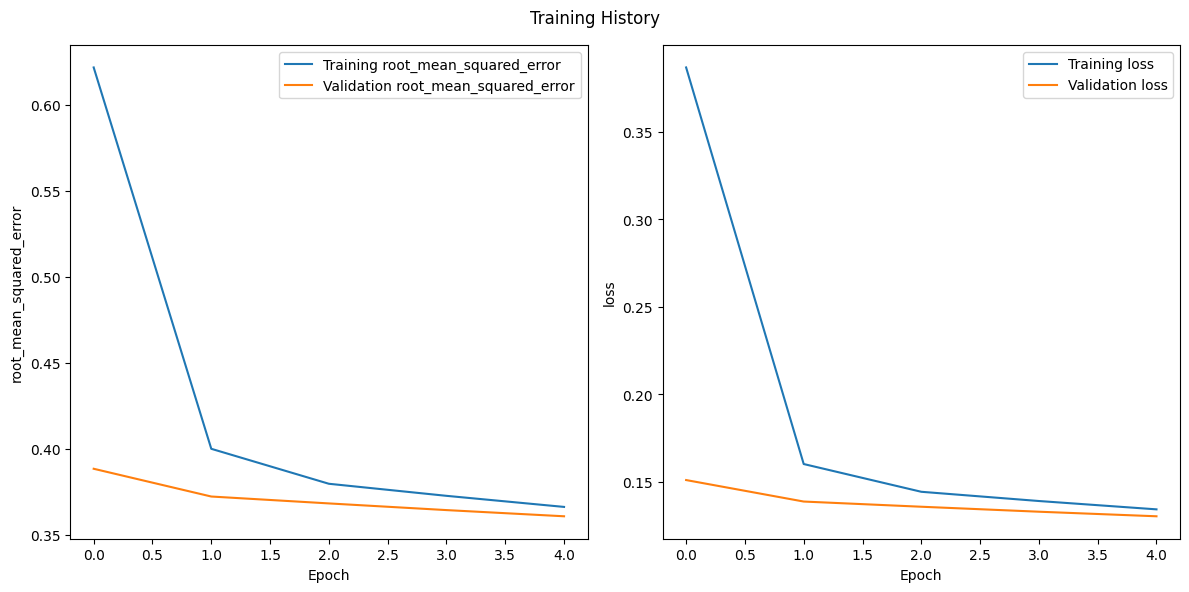

In [783]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
pd.options.mode.chained_assignment = None


# plot training history
Utils.plot_training_history(axes[0], history, "root_mean_squared_error")
Utils.plot_training_history(axes[1], history, "loss")

# Mostrar el gráfico
fig.suptitle("Training History")
fig.tight_layout()
plt.show()


In [779]:
"""
Evaluate the model over the validation data, if the metrics are not good, change the model an test again
"""
metric = model_one_shot.evaluate(val_sequence, val_labels)

print("The values of Loss and Root Mean Squared Error are: ", metric)

5390/5390 [==============================] - 90s 17ms/step - loss: 0.1302 - root_mean_squared_error: 0.3608
The values of Loss and Root Mean Squared Error are:  [0.1301526576280594, 0.36076676845550537]


train sequence: (num train data, past_data, features) -> (22, 24, 6)
label sequence: (num train data, label) ->  (22, 1)
1/1 [==============================] - 0s 49ms/step


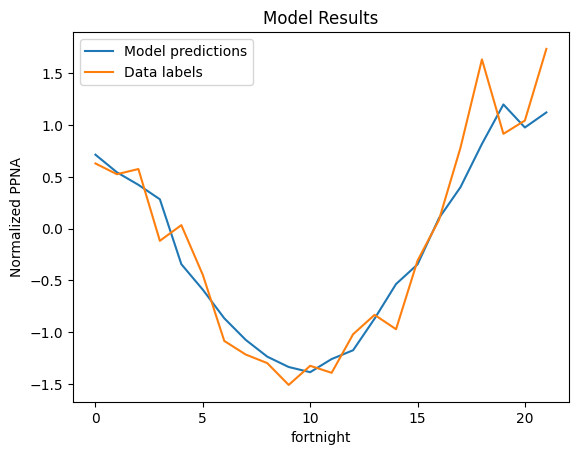

In [782]:
"""
Test the model and view the results: In this case, the model is tested over a fixed location 
"""

test_sequence_fixed_position_df = DataManager(test_df[(test_df['longitude'] == ppna_df['longitude'][400000]) & (test_df['latitude'] == ppna_df['latitude'][400000])])
test_sequence_fixed_position , test_labels_fixed_position = test_sequence_fixed_position_df.sequence_data_preparation(INPUT_STEPS, OUTPUT_STEPS)
print("train sequence: (num train data, past_data, features) ->", test_sequence_fixed_position.shape )
print("label sequence: (num train data, label) -> ", test_labels_fixed_position.shape)

predict = model_one_shot.predict(test_sequence_fixed_position)

plt.title("Model Results")
plt.plot(predict, label="Model predictions")
plt.plot(test_labels_fixed_position, label="Data labels")

# Add labels, legend, etc., as needed
plt.xlabel("fortnight")
plt.ylabel("Normalized PPNA")
plt.legend()
plt.show()

Hasta aca hay un modelo que predice los proximos 15 dias en base al historial de un año. Los proximos pasos (para mi) son


    - Agregar la informacion espacial a la red (Forecasting using spatio-temporal data -> https://stellargraph.readthedocs.io/en/stable/demos/time-series/gcn-lstm-time-series.html )
    - Hacer el modelo de feedback para que el resultado de 15 dias los use para aproximar los siguientes 15, junto con un pronostico y asi hasta llegar a 6 meses 
    - Intentar de agregar mas info (sobre todo espacial) -> forma del terreno, etc 
    
